# Importing data

In [2]:
import pandas as pd

In [3]:
routes_df = pd.read_csv("data/routes.csv")
airports_df = pd.read_csv("data/airports.csv")
#print(routes_df.keys())
#print(airports_df.keys())

In [4]:
airports_by_iata_df = airports_df.groupby("IATA")

In [5]:
airports_by_longtitude_df = airports_df.groupby("Longitude")
airports_by_lattitude_df = airports_df.groupby("Latitude")

# Creating a directed multigraph

In [6]:
import networkx as nx

In [7]:
airport_nodes = list(airports_by_iata_df.groups)

In [8]:
#Ordering matches source and destination airport.
airport_src = list(routes_df["Source airport"])
airport_dest = list(routes_df["Destination airport"])

In [9]:
airport_routes_digraph = nx.MultiDiGraph()

airport_routes_digraph.add_nodes_from(airport_nodes)
airport_routes_digraph.add_edges_from([(airport_src[i],airport_dest[i]) for i in range(len(airport_src))]);

# Plotting the graph

In [10]:
import matplotlib.pyplot as plt

In [11]:
def getLongitudeForIATA(df,IATA):
    result = list(df.loc[df['IATA'] == IATA]["Longitude"])
    if(len(result) > 0):
        return result[0]
    else:
        return 0

def getLatitudeForIATA(df,IATA):
    result = list(df.loc[df['IATA'] == IATA]["Latitude"])
    if(len(result) > 0):
        return result[0]
    else:
        return 0


In [12]:
positions = {}

for node in airport_routes_digraph.nodes:
    positions.update({node:(getLongitudeForIATA(airports_df,node),getLatitudeForIATA(airports_df,node))})    

In [13]:
options = {
    'width': 0.2,
    'alpha': 0.9,
    'node_size': 50,
    'with_labels': False
}

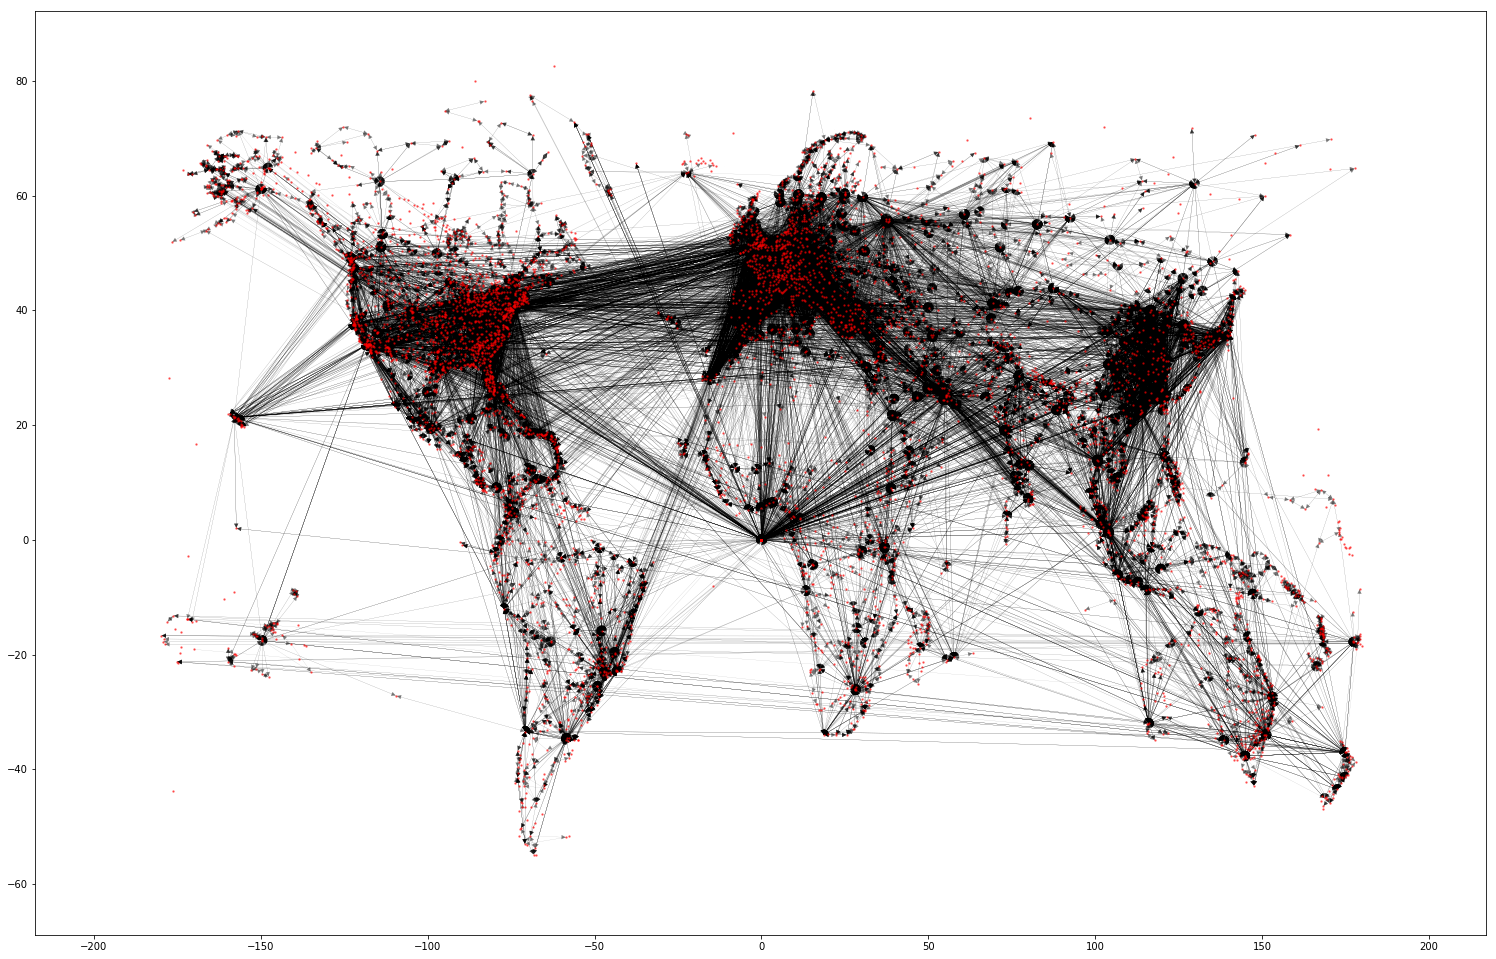

In [20]:
fig = plt.figure(figsize=(26,17))
nx.draw_networkx(airport_routes_digraph, positions, 
                 width=0.1,alpha=0.5,node_size=2,with_labels=False, 
                 ax=fig.add_subplot(111))

fig.savefig("airportgraph.png")

In [147]:
airports_df.loc[airports_df['IATA'] == "SPR"]

,Airport Id,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz database timezone,Type,Source
